In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
df = pd.read_csv('bad_samples.csv')

df.head(2)

,Access_Mask,Access_Reasons,Accesses,Account_Domain,Account_Name,Application_Name,Authentication_Package,ClientProcessId,ComputerName,Creator_Process_ID,...,host,index,linecount,punct,source,sourcetype,splunk_server,splunk_server_group,tag,tag::eventtype
0,NaN,NaN,NaN,WORKGROUP\nCLIENT-PC,CLIENT-PC$\nCommunication_LTD,NaN,NaN,NaN,CLIENT-PC,0x2fc,...,CLIENT-PC,main,NaN,//_::_====-=___.===_=_==_____.\r\r_:\rt_:tt---...,WinEventLog:Security,WinEventLog:Security,SIEM,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,-,NaN,NaN,CLIENT-PC,NaN,...,CLIENT-PC,main,NaN,//_::_====-=___.===_=___==_______.\r\r_:\rt_:t...,WinEventLog:Security,WinEventLog:Security,SIEM,NaN,NaN,NaN


In [3]:
LogName = []
Date = []
Time = []
ComputerName = []
SourceName = []
TaskCategory = []
EventType = []
Message = []
Keywords = []
OpCode = []
EventCode = []
Type = []
RecordNumber = []

for i in range(0,len(df)):
    current_log = df.iloc[i]['_raw']
    Date.append(current_log[0:10])
    Time.append(current_log[11:22])
    LogName.append(re.search('LogName=(.*)\n', current_log).group(1))
    ComputerName.append(re.search('ComputerName=(.*)\n', current_log).group(1))
    SourceName.append(re.search('SourceName=(.*)\n', current_log).group(1))
    TaskCategory.append(re.search('TaskCategory=(.*)\n', current_log).group(1))
    EventType.append(re.search('EventType=(.*)\n', current_log).group(1))
    Keywords.append(re.search('Keywords=(.*)\n', current_log).group(1))
    OpCode.append(re.search('OpCode=(.*)\n', current_log).group(1))
    EventCode.append(re.search('EventCode=(.*)\n', current_log).group(1))
    Type.append(re.search('Type=(.*)\n', current_log).group(1))
    RecordNumber.append(re.search('RecordNumber=(.*)\n', current_log).group(1))
    Message.append(re.search('Message=(.*)', current_log).group(1))

df_cleaned = pd.DataFrame({ 'LogName' : LogName,
                         'Date' : Date,
                         'Time' : Time,
                         'ComputerName' : ComputerName,
                         'SourceName' : SourceName,
                         'TaskCategory' : TaskCategory,
                         'EventType' : EventType,
                         'Keywords' : Keywords,
                         'OpCode' : OpCode,
                         'EventCode' : EventCode,
                         'Type' : Type,
                         'RecordNumber' : RecordNumber,
                         'Message' : Message })

df_cleaned.head(5)

,LogName,Date,Time,ComputerName,SourceName,TaskCategory,EventType,Keywords,OpCode,EventCode,Type,RecordNumber,Message
0,Security,08/26/2023,05:20:24 PM,CLIENT-PC,Microsoft Windows security auditing.,Process Creation,0,Audit Success,Info,4688,0,182305,A new process has been created.
1,Security,08/26/2023,05:20:24 PM,CLIENT-PC,Microsoft Windows security auditing.,Filtering Platform Packet Drop,0,Audit Failure,Info,5152,0,182306,The Windows Filtering Platform has blocked a p...
2,Security,08/26/2023,05:20:24 PM,CLIENT-PC,Microsoft Windows security auditing.,Filtering Platform Packet Drop,0,Audit Failure,Info,5152,0,182307,The Windows Filtering Platform has blocked a p...
3,Security,08/26/2023,05:20:24 PM,CLIENT-PC,Microsoft Windows security auditing.,Filtering Platform Packet Drop,0,Audit Failure,Info,5152,0,182308,The Windows Filtering Platform has blocked a p...
4,Security,08/26/2023,05:20:24 PM,CLIENT-PC,Microsoft Windows security auditing.,Filtering Platform Packet Drop,0,Audit Failure,Info,5152,0,182309,The Windows Filtering Platform has blocked a p...


Let's fix some of the features types:

In [4]:
df_cleaned['EventType'] = df_cleaned['EventType'].astype(int)
df_cleaned['EventCode'] = df_cleaned['EventCode'].astype(int)
df_cleaned['Type'] = df_cleaned['Type'].astype(int)
df_cleaned['RecordNumber'] = df_cleaned['RecordNumber'].astype(int)
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], format='%m/%d/%Y')
df_cleaned['Time'] = pd.to_datetime(df_cleaned['Time'], format='%I:%M:%S %p').dt.time

df_cleaned.dtypes

LogName                 object
Date            datetime64[ns]
Time                    object
ComputerName            object
SourceName              object
TaskCategory            object
EventType                int32
Keywords                object
OpCode                  object
EventCode                int32
Type                     int32
RecordNumber             int32
Message                 object
dtype: object

Now let's explore what event codes were generated in this attack:

<Axes: xlabel='EventCode'>

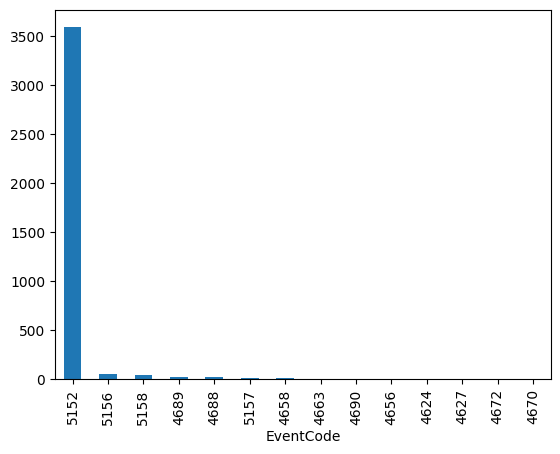

In [5]:
df['EventCode'].value_counts().plot.bar()

We can see that we have some logs here that doesn't appear as much as the others, hence they may be outliers for us.

#### <u>Removing Outliers</u>

1. We know that those logs were collected in a time when a malicious activity were happened (Port Scanning).
2. Hence, by logic we can remove some of the logs that are not related to this attack.

First, let's check the messages, to see if they related to the attack:

In [6]:
value_counts = df_cleaned['EventCode'].value_counts()
outliers = [key for key, value in value_counts.items() if value < 10]

for event_code in outliers:
    print('EventCode ' + str(event_code) + ':', df_cleaned[df_cleaned['EventCode'] == event_code]['Message'].iloc[0])

EventCode 4663: An attempt was made to access an object.
EventCode 4690: An attempt was made to duplicate a handle to an object.
EventCode 4656: A handle to an object was requested.
EventCode 4624: An account was successfully logged on.
EventCode 4627: Group membership information.
EventCode 4672: Special privileges assigned to new logon.
EventCode 4670: Permissions on an object were changed.


These specific logs don't seem to be related to the port scanning attack, as they appear only several times.<br>
Therefore, from this perspective we can delete them:

In [7]:
print('Before dropping:', len(df_cleaned))
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 4663].index, inplace=True)
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 4690].index, inplace=True)
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 4656].index, inplace=True)
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 4624].index, inplace=True)
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 4627].index, inplace=True)
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 4672].index, inplace=True)
df_cleaned.drop(df_cleaned.loc[df_cleaned['EventCode'] == 4670].index, inplace=True)
print('After dropping:', len(df_cleaned))

value_counts = df_cleaned['EventCode'].value_counts()
print('Values after drop:', value_counts)

Before dropping: 3762
After dropping: 3740
Values after drop: EventCode
5152    3586
5156      53
5158      41
4689      20
4688      19
5157      11
4658      10
Name: count, dtype: int64


Let's see what logs we left with:

In [8]:
value_counts = df_cleaned['EventCode'].value_counts()

for pair in value_counts.items():
    print('EventCode ' + str(pair[0]) + ':', df_cleaned[df_cleaned['EventCode'] == pair[0]].iloc[0]['Message'])

EventCode 5152: The Windows Filtering Platform has blocked a packet.
EventCode 5156: The Windows Filtering Platform has permitted a connection.
EventCode 5158: The Windows Filtering Platform has permitted a bind to a local port.
EventCode 4689: A process has exited.
EventCode 4688: A new process has been created.
EventCode 5157: The Windows Filtering Platform has blocked a connection.
EventCode 4658: The handle to an object was closed.


Now that we removed the outliers, we can save our data set as <b>'bad_samples_cleaned.csv'</b>:

In [9]:
df_cleaned.to_csv('bad_samples_cleaned.csv', index=False)

And let's save another reducted version of the dataset:

In [10]:
df_cleaned_reducted = df_cleaned.iloc[0:300]
df_cleaned_reducted.to_csv('bad_samples_cleaned_port_scanning_reducted.csv', index=False)